In [0]:
#installing keras-efficientnets libraries to use pretrained efficient nets in keras frame work
!pip install keras-efficientnets

In [0]:
#importing requirements
from google.colab.patches import cv2_imshow
import os
import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from zipfile import ZipFile
import shutil
from PIL import Image
from keras.activations import tanh
from keras.optimizers import Adam 
from keras.layers import Dense ,Conv2D ,Multiply ,MaxPooling2D ,Dropout ,Activation ,Flatten ,Input ,concatenate ,Conv2DTranspose
from keras.models import Model
from keras_efficientnets import EfficientNetB2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn.metrics import accuracy_score, precision_score ,recall_score ,f1_score ,roc_auc_score ,confusion_matrix
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
#mounting the drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#creating datagenarator fro training ,testing and validating
#the directories are to be manipulated according to the location of your dataset
train_datagen = ImageDataGenerator(1/255.0)
test_datagen = ImageDataGenerator(1/255.0)
parent_dir = '/content/gdrive/My Drive/segment-cropped-dataset/'
train_generator = train_datagen.flow_from_directory(
    parent_dir + 'train',
    target_size=(224, 224),batch_size = 32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    parent_dir + 'valid',
    batch_size = 32,
    target_size=(224, 224),
    class_mode='categorical')

Found 5116 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [0]:
#importing pretrained efficinetnet B2 with imagenet weights
efficient_net = EfficientNetB2((224,224,3), include_top=False, weights='imagenet')

31817728/31812944 [==============================] - 1s 0us/step


In [0]:
#printing the summary
efficient_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
#custom focal loss function
#focal loss function deal with the class imbalance if any
def myloss(alpha ,gamma):
    def focal_loss(y_true ,y_pred):
        y_pred = K.clip(y_pred ,1e-8 ,1-1e-8)
        log_lik = y_true*K.log(y_pred)
        loss = alpha*((1-y_pred)**gamma)*log_lik
        return -K.sum(loss)
    return focal_loss

In [0]:
#attention mechanism for the model
def attention_layer(flatten):
    activation = Activation(tanh)(flatten)
    activation = Dropout(0.2)(activation)
    softmax_layer = Dense(1408 ,activation = 'softmax')(activation)
    multiplied =  Multiply()([softmax_layer ,flatten])
    return multiplied

In [0]:
#building and compiling the model
input_ = efficient_net.output
print(tf.shape(input_))
#Conv_layer = Conv2D(2048 ,(3,3) ,kernel_initializer = 'glorot_uniform' ,activation = 'elu')(input_)
max_pool = MaxPooling2D((5 ,5))(input_)
flatten = Flatten()(max_pool)
attention_output = attention_layer(flatten)
final_softmax = Dense(2 ,activation = 'softmax')(attention_output)
model = Model(inputs = efficient_net.input ,outputs = [final_softmax])
model.summary()
model.compile(loss = myloss(2.0 ,1.5) ,optimizer = Adam(lr = 0.000005) ,metrics = ['acc'])

Tensor("Shape:0", shape=(4,), dtype=int32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 32) 0           batch_normalization_1[0][0]      
_________________________________________________

In [0]:
#the plan is to export the efficient net trained on the pneumonia chest dataset and fine tuning the model with covid dataset (centre cropped and segmentation based cropped dataset
#and then ensemble ).So the main base model is saved here.
main_model = Model(inputs = [efficient_net.input] ,outputs = [input_] )
filepath='\content\gdrive\My Drive\covid results\covid_checkpoints\seg_eff'+'\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
#training
history = model.fit_generator(train_generator ,steps_per_epoch = 5116//32 , epochs = 30 ,validation_data = validation_generator ,callbacks=callbacks_list)

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


159/159 [==============================] - 1798s 11s/step - loss: 15.2976 - acc: 0.7250 - val_loss: 9.4673 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to \content\gdrive\My Drive\covid results\covid_checkpoints\seg_eff\weights-improvement-01-0.50.hdf5
Epoch 2/30
159/159 [==============================] - 189s 1s/step - loss: 13.1518 - acc: 0.7504 - val_loss: 8.6305 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/30
159/159 [==============================] - 183s 1s/step - loss: 10.4070 - acc: 0.7681 - val_loss: 7.2827 - val_acc: 0.5603

Epoch 00003: val_acc improved from 0.50000 to 0.56034, saving model to \content\gdrive\My Drive\covid results\covid_checkpoints\seg_eff\weights-improvement-03-0.56.hdf5
Epoch 4/30
159/159 [==============================] - 184s 1s/step - loss: 7.7732 - acc: 0.8153 - val_loss: 8.7351 - val_acc: 0.7069

Epoch 00004: val_acc improved from 0.56034 to 0.70690, saving model to \content\gdriv

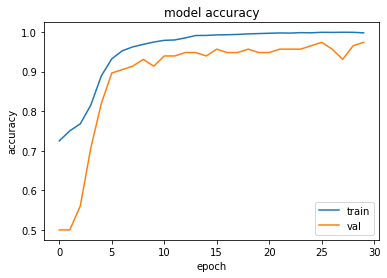

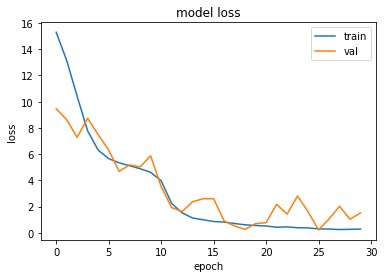

In [0]:
#learning curves
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
#test_generator for testing
test_generator = test_datagen.flow_from_directory(
    parent_dir + 'test',
    batch_size = 32,
    target_size=(224, 224),
    class_mode='categorical')

Found 624 images belonging to 2 classes.


In [0]:
#evaluating the model
model.evaluate_generator(test_generator ,verbose = 1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


20/20 [==============================] - 221s 11s/step


[8.268550872802734, 0.8333333134651184]

In [0]:
#prediction generator for predicting the classes of test dataset
#collecting true and predicted classes
prediction_generator = test_datagen.flow_from_directory(
    parent_dir + 'test',
    batch_size = 32,
    target_size=(224, 224),
    class_mode=None)
y_true = prediction_generator.classes
y_pred = model.predict_generator(prediction_generator ,verbose = 1)

Found 624 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


20/20 [==============================] - 6s 314ms/step


In [0]:
#decoding the class
y_pred_cls = []
for i in range(y_pred.shape[0]):
    k = np.argmax(y_pred[i])
    y_pred_cls.append(k)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


[[ 57 177]
 [ 79 311]]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


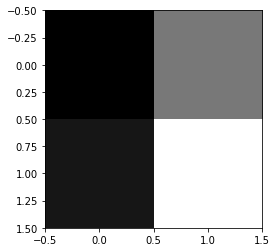

In [0]:
#plotting the confusion matrix
k = confusion_matrix(y_true ,y_pred_cls)
print(k)
plt.imshow(k ,cmap = 'gray')

In [0]:
#accuracy_score ,precision score ,recall score ,f1 score
acc_score = accuracy_score(y_true ,y_pred_cls)
pre_score = precision_score(y_true ,y_pred_cls,average = 'micro')
recall = recall_score(y_true ,y_pred_cls ,average = 'micro')
f1 = f1_score(y_true ,y_pred_cls ,average = 'micro')

print('accuracy score : {}'.format(acc_score))
print('precision score : {}'.format(pre_score))
print('recall score : {}'.format(recall))
print('f1 score : {}'.format(f1))

accuracy score : 0.5897435897435898
precision score : 0.5897435897435898
recall score : 0.5897435897435898
f1 score : 0.5897435897435898


In [0]:
 #model layers
 model.layers

In [0]:
#defining a function to plot grad cam maps
def grad_cam(image, cls):
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.layers[-8].output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (224 ,224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

[[0.5015317  0.49846822]]


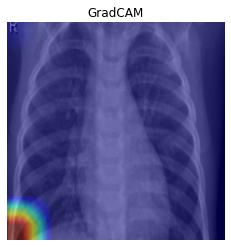

In [0]:
#plotting gradcam map for random image belonging to 'NORMAL' class
#again the directories can be adjusted accordingly
test_image_dir = parent_dir + 'test'
healthy_images = os.listdir(test_image_dir + '/NORMAL')
pneumonia_images = os.listdir(test_image_dir + '/PNEUMONIA')
img = cv2.imread(test_image_dir+'/NORMAL/'+healthy_images[52])
pro_img = cv2.resize(img ,(224 ,224))/255
print(model.predict(pro_img.reshape(1,224,224,3)))
cam = grad_cam(pro_img.reshape(1,224,224,3) ,cls = 0)
plt.title('GradCAM')
plt.axis('off')
plt.imshow(cv2.resize(img ,(224 ,224)))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()

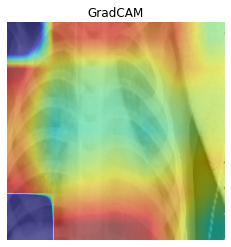

In [0]:
#plotting gradcam map for random image belonging to 'PNEUMONIA' class
test_image_dir = parent_dir + 'test'
healthy_images = os.listdir(test_image_dir + '/NORMAL')
pneumonia_images = os.listdir(test_image_dir + '/PNEUMONIA')
img = cv2.imread(test_image_dir+'/PNEUMONIA/'+pneumonia_images[115])
pro_img = cv2.resize(img ,(224 ,224))/255
cam = grad_cam(pro_img.reshape(1,224,224,3) ,cls = 1)
plt.title('GradCAM')
plt.axis('off')
plt.imshow(cv2.resize(img ,(224 ,224)))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()

In [0]:
#svaing the main model
main_model.save('/content/gdrive/My Drive/covid results/eff_net_seg.h5')